<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter06/Class_activation_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import os
# if not os.path.exists('cell_images'):
#     !pip install -U -q torch_snippets
#     !wget -q ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
#     !unzip -qq cell_images.zip
#     !rm cell_images.zip
# from torch_snippets import *

In [3]:
from torch_snippets import *
from torch_snippets.torch_loader import *

import torch.optim as optim
import torch
from torchvision import transforms as T
import torch.nn as nn
import cv2

In [4]:
# import kagglehub
# import os

# os.environ['KAGGLE_CONFIG_DIR']=r"C:\Users\hunter\Desktop\kaggle.json"
# #os.environ['KAGGLE_USERNAME']="ggzone"
# #os.environ['KAGGLE_KEY']="14a4fd12896b638b1758c36dd58b3932"


# # Download latest version ,r"D:\open-source\mcvp-packt\Chapter06"
# path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

# print("Path to dataset files:", path)

In [5]:
id2int = {'Parasitized': 0, 'Uninfected': 1}

In [6]:
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ColorJitter(brightness=(0.95,1.05), 
                  contrast=(0.95,1.05), 
                  saturation=(0.95,1.05), 
                  hue=0.05),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], 
                std=[0.5, 0.5, 0.5]),
])

In [7]:
val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], 
                std=[0.5, 0.5, 0.5]),
])

In [8]:
from torch.utils.data import Dataset,DataLoader
class MalariaImages(Dataset):

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        #clss = fname(parent(fpath))
        clss =fpath.parent.name
        img = read(fpath, 1)
        # print(f'{fpath},{parent(fpath)}')
        return img, clss

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes, _imgs

In [9]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('cell_images/*/*.png')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = MalariaImages(trn_files[:1000], transform=trn_tfms)
val_ds = MalariaImages(val_files[:1000], transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

[12/07/24 15:01:18] INFO     1000                                                                                                                    ]8;id=726194;file://C:\Users\hunter\AppData\Local\Temp\ipykernel_29456\400510360.py:7\400510360.py]8;;\:]8;id=409035;file://C:\Users\hunter\AppData\Local\Temp\ipykernel_29456\400510360.py:7#__init__:7\__init__:7]8;;\

                    INFO     1000                                                                                                                    ]8;id=448267;file://C:\Users\hunter\AppData\Local\Temp\ipykernel_29456\400510360.py:7\400510360.py]8;;\:]8;id=93851;file://C:\Users\hunter\AppData\Local\Temp\ipykernel_29456\400510360.py:7#__init__:7\__init__:7]8;;\

In [10]:
# ti=T.ToPILImage()
# ti(val_ds[0][0]).show()

In [11]:


def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )
    
class MalariaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 256),
            convBlock(256, 512),
            convBlock(512, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return loss, acc

In [12]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels, _ = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels, _ = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

In [13]:
model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 2

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx,data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000  trn_acc: 0.605  trn_loss: 0.680  val_acc: 0.670  val_loss: 0.624  (65.69s - 65.69s remaining)
EPOCH: 2.000  trn_acc: 0.776  trn_loss: 0.470  val_acc: 0.929  val_loss: 0.297  (110.00s - 0.00s remaining)


In [14]:
im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

In [35]:
im2fmap

Sequential(
  (0): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [55]:
def im2gradCAM(x):
    model.eval()
    logits = model(x)
    print(logits.shape)
    print(logits)
    heatmaps = []
    activations = im2fmap(x)
    print(activations.shape)
    pred = logits.max(-1)[-1]
    print(logits.max(-1))
    print(pred)
    # get the model's prediction
    model.zero_grad()
    # compute gradients with respect to model's most confident logit
    logits[0,pred].backward(retain_graph=True)
    # get the gradients at the required featuremap location
    # and take the avg gradient for every featuremap
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1,2,3))
    # multiply each activation map with corresponding gradient average
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]
    # take the mean of all weighted activation maps
    # (that has been weighted by avg. grad at each fmap)
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

In [99]:
print(model.model[-6][1])
print(model.model[-7][1])
print(model.model[-6][1].weight.grad.data.shape)
print(model.model[-6][1].weight.grad.data.mean((1)).shape)
print(model.model[-6][1].weight.grad.data.mean((2)).shape)
print(model.model[-6][1].weight.grad.data.mean((3)).shape)
print(model.model[-6][1].weight.grad.data.mean((1,2,3)).shape)

Conv2d(512, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([64, 512, 3, 3])
torch.Size([64, 3, 3])
torch.Size([64, 512, 3])
torch.Size([64, 512, 3])
torch.Size([64])


In [16]:
SZ = 128
def upsampleHeatmap(map, img):
    m,M = map.min(), map.max()
    map = 255 * ((map-m) / (M-m))
    map = np.uint8(map)
    map = cv2.resize(map, (SZ,SZ))
    map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
    map = np.uint8(map)
    map = np.uint8(map*0.7 + img*0.3)
    return map

torch.Size([1, 2])
tensor([[ 0.5247, -0.2488]], grad_fn=<AddmmBackward0>)
torch.Size([1, 64, 4, 4])
torch.return_types.max(
values=tensor([0.5247], grad_fn=<MaxBackward0>),
indices=tensor([0]))
tensor([0])


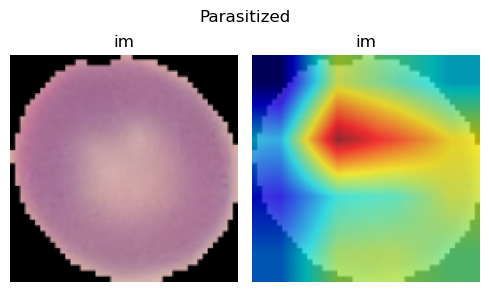

In [57]:
N = 1
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

for i in range(N):
    image = resize(z[i], SZ)
    heatmap, pred = im2gradCAM(x[i:i+1])
    if(pred=='Uninfected'):
        continue
    heatmap = upsampleHeatmap(heatmap, image)
    subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)

In [45]:
model

MalariaClassifier(
  (model): Sequential(
    (0): Sequential(
      (0): Dropout(p=0.2, inplace=False)
      (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Dropout(p=0.2, inplace=False)
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Dropout(p=0.2, inplace=False)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [53]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1          [-1, 3, 128, 128]               0
            Conv2d-2         [-1, 64, 128, 128]           1,792
              ReLU-3         [-1, 64, 128, 128]               0
       BatchNorm2d-4         [-1, 64, 128, 128]             128
         MaxPool2d-5           [-1, 64, 64, 64]               0
           Dropout-6           [-1, 64, 64, 64]               0
            Conv2d-7           [-1, 64, 64, 64]          36,928
              ReLU-8           [-1, 64, 64, 64]               0
       BatchNorm2d-9           [-1, 64, 64, 64]             128
        MaxPool2d-10           [-1, 64, 32, 32]               0
          Dropout-11           [-1, 64, 32, 32]               0
           Conv2d-12          [-1, 128, 32, 32]          73,856
             ReLU-13          [-1, 128, 32, 32]               0
      BatchNorm2d-14          [-1, 128,

In [49]:
x,y,z = next(iter(_val_dl))
x[0].shape

torch.Size([3, 128, 128])